<h1><center>Generalized Low Rank Models on the Palmer penguins data set</center></h1>

![image1](https://github.com/allisonhorst/palmerpenguins/blob/master/man/figures/lter_penguins.png?raw=true)
Artwork by @allison_horst”

## Data Source by  `Alison Horst`
https://github.com/allisonhorst/palmerpenguinsm

### Import libaries and start H2O

In [1]:
from h2o.estimators import H2OGeneralizedLowRankEstimator
from sklearn.metrics import pairwise
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import preprocessing

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h2o

scaler = StandardScaler()

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/jcarde20/Library/Python/3.8/lib/python/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmp0fzn_x8r
  JVM stdout: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmp0fzn_x8r/h2o_jcarde20_started_from_python.out
  JVM stderr: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmp0fzn_x8r/h2o_jcarde20_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,7 months and 20 days !!!
H2O_cluster_name:,H2O_from_python_jcarde20_ei29po
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


### Load Data on pandas

In [4]:
penguins = pd.read_csv('../data/penguins.csv')

# rename cols
penguins.rename( columns=dict(species = 'species_', island='island_'), inplace=True )

In [5]:
penguins.head(10)

,species_,island_,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [92]:
penguins.shape

(344, 7)

In [6]:
num_cols = ['bill_length_mm', 'bill_depth_mm','flipper_length_mm','body_mass_g']
bol_cols = ['sex']
cat_cols = ['island_','species_']

## clean cont data

In [7]:
ste = preprocessing.StandardScaler()
ste.fit(penguins[num_cols])

penguins[ num_cols ] = ste.transform(penguins[num_cols])

### Load data onto H2O

In [8]:
# convert to h2o frame
A = h2o.H2OFrame(   penguins   )  # we need to drop the nan


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [93]:
A.shape

(344, 7)

### Define Factor Columns onto H2O

In [9]:
for C in bol_cols + cat_cols:
    A[C] = A[C].asfactor()

In [10]:
print( 'The size of the original data is: \n- rows = {0}\n- cols = {1}'.format(*A.shape))

The size of the original data is: 
- rows = 344
- cols = 7


In [11]:
A.head(3)

species_,island_,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
Adelie,Torgersen,-0.884499,0.785449,-1.41835,-0.564142,MALE
Adelie,Torgersen,-0.811126,0.126188,-1.06225,-0.501703,FEMALE
Adelie,Torgersen,-0.66438,0.430462,-0.421277,-1.18853,FEMALE


## Split data

In [12]:
# Split the dataset into a train and valid set:
train, test = A.split_frame(ratios=[.7], seed=1234)

## Custom Function

In [99]:
def glrm(A_h2o_df, Rank=2, Xreg= None, Yreg=None, gamma_x=None, gamma_y=None, seed=42, svd_method='Randomized'):
    ## Build and train the model:
    
    model = H2OGeneralizedLowRankEstimator(k= Rank,
                                            loss= 'Quadratic' ,
                                            transform= 'Standardize', # for numeric
                                            gamma_x= gamma_x,
                                            gamma_y= gamma_y,
                                            impute_original=False,
                                            max_iterations=700,
                                            recover_svd=True,
                                            init="SVD",
                                            svd_method= svd_method ,
                                            regularization_x = Xreg,
                                            regularization_y = Yreg,
                                            representation_name ='my_very_cool_X',
                                            seed = seed)

    
    model.train(training_frame = A_h2o_df)
    
    # archetypes
    Y = model._model_json["output"]['archetypes'].as_data_frame().drop('',axis=1)
    
    X = h2o.get_frame(model._model_json["output"]["representation_name"]).as_data_frame()
    X.columns = ['x' + i.split('Arch')[1] for i in X.columns]
    
    
    R=dict()
    R['glrm'] = model
    R['X'] = X
    R['Y'] = Y
    R['Y_encoded_from_train'] = model.proj_archetypes(A)
    
    return R
    
    
    

### Low Rank model

In [100]:
%%time
Yreg =  'L2'
Xreg =  'L2'
Gamma= 1
rank = 4

lrm = glrm(  A, Rank =  rank, Xreg = Xreg, Yreg = Yreg, gamma_x= Gamma, gamma_y= Gamma, svd_method='GramSVD')

glrm Model Build progress: |██████████████████████████████████████████████| 100%
CPU times: user 27.9 ms, sys: 8.96 ms, total: 36.9 ms
Wall time: 258 ms


## Output and convergence

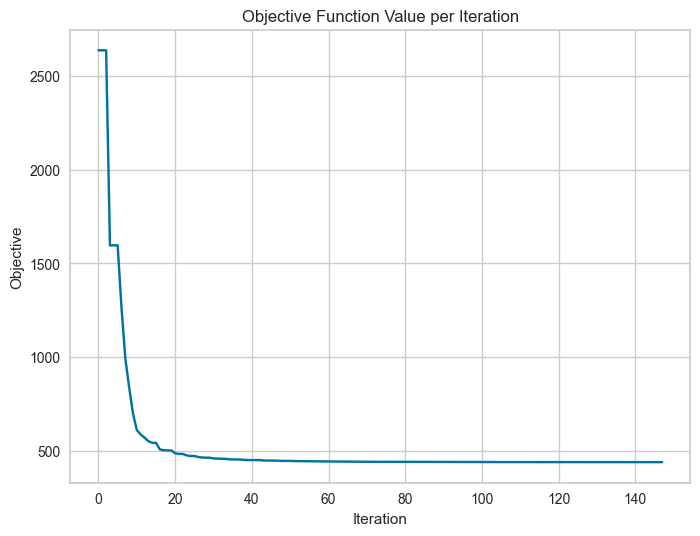

In [101]:
# Plot objective function value each iteration
glrm_score = lrm['glrm'].score_history()

plt.figure(dpi=100, figsize=(8,6))
plt.plot(glrm_score["iterations"], glrm_score["objective"])
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.show()

In [102]:
#lrm['glrm']._model_json["output"]

In [103]:
lrm['glrm'].predict(test)

glrm prediction progress: |███████████████████████████████████████████████| 100%


reconstr_species_,reconstr_island_,reconstr_bill_length_mm,reconstr_bill_depth_mm,reconstr_flipper_length_mm,reconstr_body_mass_g,reconstr_sex
Adelie,Torgersen,-1.36797,1.12354,-0.880823,-0.468252,MALE
Adelie,Torgersen,-1.56452,0.566639,-0.773371,-0.498625,nan
Adelie,Torgersen,-1.13683,0.859679,-0.595212,-0.270185,MALE
Adelie,Torgersen,-1.53626,1.92448,-0.605464,0.228835,MALE
Adelie,Torgersen,-0.46838,1.94357,-0.273803,0.422134,MALE
Adelie,Torgersen,-2.20443,0.553333,-1.29272,-1.01155,FEMALE
Adelie,Torgersen,-0.413959,2.41979,-0.403927,0.371423,MALE
Adelie,Biscoe,-1.46225,0.107228,-1.06281,-0.952304,FEMALE
Adelie,Biscoe,-1.3343,0.88806,-0.75497,-0.294731,MALE
Adelie,Biscoe,-1.42028,0.165612,-0.838972,-0.64702,FEMALE


## `Y`  

In [104]:
lrm['Y']

,species_adelie,species_chinstrap,species_gentoo,island_biscoe,island_dream,island_torgersen,sexfemale,sexmale,sexnan,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,4.103814,-0.028108,-5.247106,-6.166707,2.110879,2.058700,1.347136,-1.338581,-1.174547,-1.941816,1.776074,-2.446215,-2.330267
1,-1.094737,3.988277,0.833144,-2.818002,0.640065,3.511355,-1.606845,1.435973,5.226229,0.799089,0.321208,0.509782,0.481800
2,-0.794172,1.050819,-1.692499,-1.582202,3.555440,-2.188301,-4.308267,5.018605,-1.737917,1.452365,1.690110,0.187917,0.453396
3,-3.731864,3.475769,0.074547,-1.043308,4.694230,-2.384316,3.897801,-3.294122,0.940295,0.993589,-0.837670,-0.129787,-0.759516


## `X` 

In [105]:
lrm['X']

,x1,x2,x3,x4
0,0.354249,-0.128056,0.065069,-0.404200
1,0.323687,-0.162733,-0.225944,-0.172180
2,0.327479,-0.161390,-0.223023,-0.169566
3,0.356869,0.272961,-0.407246,-0.592499
4,0.371377,-0.157500,-0.226494,-0.187042
...,...,...,...,...
339,-0.817973,-0.104690,-0.393932,-0.079478
340,-0.486823,-0.377354,-0.162420,0.125077
341,-0.667708,-0.229975,0.210379,-0.230795
342,-0.462577,-0.372496,-0.221623,0.017967


## Feature plot in 2D space 

In [106]:
import plotly.express as px

def scatter_plot(dframe, Xcol, Ycol, size=2):
    D = dframe.copy()
    D['size'] = size
    D = D.reset_index()
    D['symbol'] = ['categorical','categorical', 'categorical', 'categorical', 'categorical', 'categorical'
               , 'boolean', 'boolean', 'boolean'
               , 'numeric', 'numeric', 'numeric', 'numeric']
    
    fig = px.scatter(data_frame= D, x= Xcol, y=Ycol,size='size',
                 hover_name='index',symbol='symbol',color='symbol')
    
    fig.write_html("Y2D.html")
    
Y2 = lrm['Y'].T.copy()
Y2.columns = ['dim_' + str(i )for i in np.arange(1,len(Y2.columns)+1) ]

In [107]:
scatter_plot(Y2,'dim_1','dim_2',size=1)

## Y clustering

In [108]:
from sklearn import preprocessing as pp
from sklearn.cluster     import KMeans
from sklearn.datasets    import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances



def clustering(Xdata, k=3):
    # Instantiate the clustering model and visualizer
    #model = KMeans(random_state=0)
    #visualizer = KElbowVisualizer(model, k=(2,12))

    #visualizer.fit(Xdata)        # Fit the data to the visualizer
    #visualizer.show()        # Finalize and render the figure

    model = KMeans(n_clusters=k, random_state=0)
    visualizer = InterclusterDistance(model)

    visualizer.fit(Xdata)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(Xdata)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

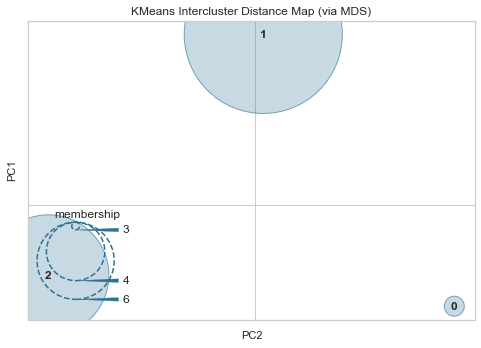

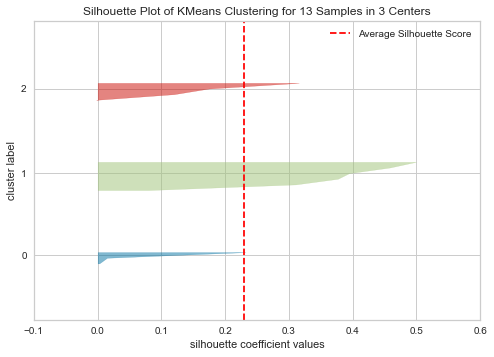

In [109]:
clustering(lrm['Y'].T)

## `X` clustering

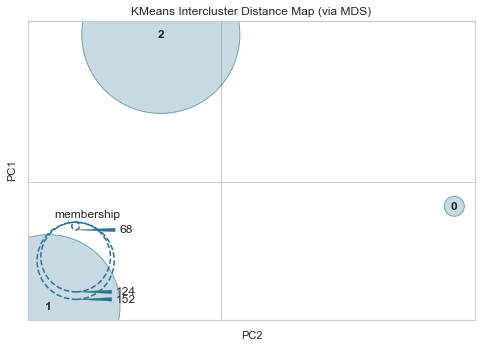

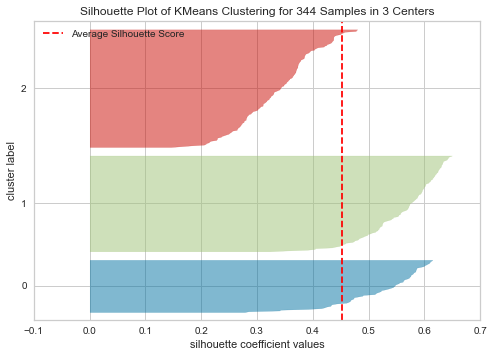

In [110]:
clustering(lrm['X'])

## Logistic Regression 

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import scikitplot as skplt

def LR(Xdata, Ydata, T=''):
    
    clf = LogisticRegression(C= 1, fit_intercept=False ,solver='liblinear',penalty='l1',max_iter=10000)
    
    X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.10, random_state=42)
    
    
    mdl = clf.fit(X_train, y_train)
    
    y_probas = mdl.predict_proba(X_test)
    
    skplt.metrics.plot_roc(y_test, y_probas)
    
    return 
    

## - Original data

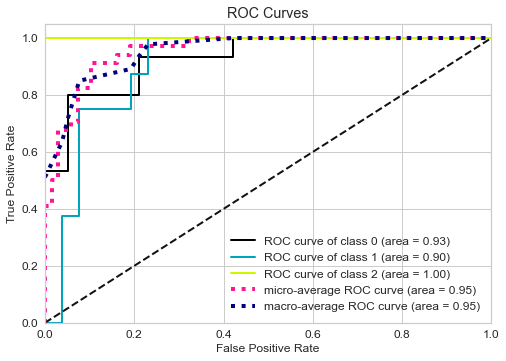

In [118]:
# Predictors
Xdata = penguins.dropna().drop('species_',axis =1)
Xdata = pd.get_dummies(Xdata)
Xdata[num_cols] = preprocessing.StandardScaler().fit_transform(Xdata[num_cols])

#Target
sp = penguins.dropna()['species_']
le_species = preprocessing.LabelEncoder().fit(sp)
target = le_species.transform( sp )

LR(Xdata[ list(np.random.choice(Xdata.columns,3)) ],target )

## - Reduced Representation

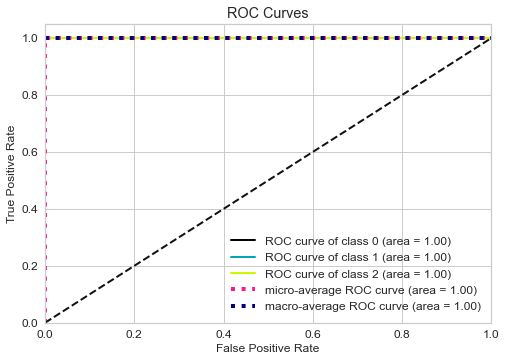

In [120]:
#Target
sp = penguins['species_']
le_species = preprocessing.LabelEncoder().fit(sp)
target = le_species.transform( sp )

LR( lrm['X'], target )

# shutdown H2O cluster

In [121]:
h2o.cluster().shutdown()

H2O session _sid_8b9c closed.
